# Electron degradation

This notebook builds a tool for parameter exploration for the processes involved in electron degradation. The processes are:

- **Plasma losses:** Coulomb interactions with free thermal electrons.
    - Huba2013 (in the limit with the $\beta$-particle energy far exceeds that of the electrons).
- **Bremsstrahlung**:
    - Barnes&Kasen2016 (corrected):  Includes tabulated cross-sections from Seltzer&Berger for various compositions. Typo corrected: eq.13 $r_0$ is incorrect and replaced by $r_e$. Includes screening at low energies.
    - Bethe1934: Does not include screening at low energies.
- **Ionization/Excitation**:
    - Barnes&Kasen2016: includes excitation and ionization for averaged comopsition (one set of values for $A$ and $Z$).
    - Bethe formulation (from Kasen&Barnes2019): non-relativistic. Only includes ionization.
- **Synchrotron**
    - Barnes&Kasen2016: total synchrotron radiated energy for a single electron.

### Exploring the different contributions to the energy loss rate for accelerated electrons.

We start with a bunch of constants and utility functions:

In [1]:
'''
This code outputs the energy loss rates following Barnes&Kasen2016
(ApJ 829:110, 2016)
Section 3: Thermalisation physics.
Processes by which energetic decay products thermalize in the KN ejecta.
Focus on beta-particles.
(Taken from ./energyLossrates.py)
'''

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import sys
import textwrap
import matplotlib.style as style
style.use('special')

# Constants
e_ = 4.80320425e-10 # elementary charge (statcoulomb) (CGS)
lambda_ee_ = 10  # Coulomb logarithm for electron-electron scattering
m_e_ = 9.10938356e-28  # electron mass (g)
m_p_ = 1.6726219e-24 # proton mass (g)
r_e_ = 2.8179403227e-13  # classical electron radius (cm)
m_u_ = 1.660539e-24  # nuclear mass unit (g)
c_ = 2.99792458e10  # light speed (cm/s)
kB_ = 8.617333262145e-11  # Boltzmann constant (MeV/K)
Msun_ = 2.0e33 # Solar mass (g)
r_0_ = 1.8e-13 # nuclear radius coef for deformed post-scission nuclei (cm)
alpha_ = 1./137. # fine structure constant 
h_bar_ = 1.0546e-27 # reduced plank constant (cm2 g s-1) (CGS)
eps_0_ = 1. # vacuum permittivity (unity in CGS)

delta_ = 1  # power-law profile for inner ejecta (Barnes&Kasen2016)
n_ = 1  # power-law profile for outer ejecta (Barnes&Kasen2016)


def to_erg(E):
    return(E*1.60218e-6)


def to_MeV(E):
    return(E/1.60218e-6)

/Users/elay7268/opt/miniconda3/envs/elec_degrad/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring


#### Plasma losses
Coulomb interactions with free thermal electrons. In the limit that the $\beta$-particle energy far exceeds that of thermal electrons, **Huba2013** gives:

$\dot{E}^\mathrm{pl}_\beta = 7.7 \times 10^{-15} E_\beta^{-1/2} \times \left(\frac{n_e}{1 \mathrm{cm}^{-3}} \right)
\lambda_{ee} \left( 1.0 - \frac{3.9}{7.7} \frac{T}{E_\beta} \right) \mathrm{MeV~s}^{-1}$

In [2]:
def plasma_losses(E_beta, n_e, T):
    ''' Returns beta_particle losses from interaction with free thermal
    electrons (MeV/s).
    args:
    E_beta = beta-particle kinetic energy (MeV)
    n_e = free electron number density (cm-3)
    T = ejecta temperature (MeV)
    '''

    return(7.7e-15 
           * E_beta**(-.5) 
           * n_e * lambda_ee_ 
           * (1. - (3.9 / 7.7) * T / E_beta))

This assumes that the dominating interactions are electron/electron (ignoring electron/ion interactions). This depends on the density of free thermal electrons, and thus the composition of the medium. It is not clear in Barnes&Kasen2016 whether they assume that all free thermal electrons only come from atoms heavier than hydrogen.

**The composition does not evolve significantly over the course of 1-10 days.**

- Inner ejecta: single component mean composition Z=60 A=144
- Outer ejecta: 2-component: Hydrogen Z=1 A=1, heavy elems Z=55 A=133\
But that hydrogen does not contribute to plasma because it is only singly ionised. Decray of neutrons into protons. A says it should be a small mass component.

Axelrod has discussion on this.

#### IE losses
When $\beta$-particles are exciting or ionizing bound atomic electrons.

We expect Barnes and Bethe to agree at high energies because Ionization starts dominating, and Bethe does not include a proper description of Excitation only. This ignores relativistic corrections however, which could explain the discrepancy at high energies.

*Barnes:*

$\dot{E}_\beta^\mathrm{IE} = 
\frac{2\pi r_e^2 m_e c^3 n_\mathrm{e,b}}{v_\beta/c} 
\times [ 2\ln(E_\beta/\bar{I}) + \ln(1+\tau/2) + (1+v_\beta^2/c^2)g(\tau)]$

$g(\tau) = 1+ \frac{\tau^2}{8} - (2\tau+1)\ln2$

*Comments:*
- Dependency on composition comes through $\bar{I}$ (Average Ionization and Excitation potential).
- Tau is a measure of the particle kinetic energy normalised by rest-mass energy.

In [3]:
def calc_n_eb(rho, z_over_a):
    ''' Returns the bound electron number density (cm-3) for a given
    average Z/A.
    args:
    rho = mass density (g/cm-3)
    z_over_a = composition (0.4 inner / 0.55 outer ejecta)
    '''
    return(rho / m_u_ * z_over_a)


def IE_Barnes(E_beta, Ibar, v_beta, n_eb, chi=1, get_name=False):
    ''' Returns beta_particle losses due to ionization and excitation
    of atomic electrons (MeV/s).
    args:
    E_beta = beta-particle kinetic energy (MeV)
    I_bar = average ionization and excitation potential (MeV) (eq. 9)
    v_beta = beta-particle speed (cm/s)
    n_eb = bound electron number density (cm-3) 
    '''
    
    _ = chi
    
    if get_name:
        return("IE_Barnes")

    tau = to_erg(E_beta) / (m_e_ * c_**2) 
    g = 1 + tau**2 / 8 - (2*tau+1) * np.log(2)
    Edot_IE = 2*np.pi * r_e_**2 * m_e_ * c_**3 * n_eb / (v_beta/c_)
    Edot_IE *= (2 * np.log(E_beta/Ibar) 
                + np.log(1 + tau/2) 
                + (1 - (v_beta/c_)**2) * g)

    return(to_MeV(Edot_IE))

def IE_Bethe(E_beta, I_bar, v_beta, n_eb, chi=1, get_name=False):
    '''Returns beta_particle losses due to ionization
    of atomic electrons (MeV/s). Does not include excitation.
    From the Bethe formula as reported in Kasen&Barnes2019 eq. 5.
    args:
    E_beta = beta-particle kinetic energy (MeV)
    chi = effective ionization potential (=1 for non-relativistic e-)
    v_beta = beta-particle speed (cm/s)
    n_eb = bound electron number density (cm-3) 
    '''
    
    _ = I_bar
    
    if get_name:
        return("IE_Bethe")
    
    E_beta_tot = m_e_ * c_**2 + to_erg(E_beta)  # total energy
    cst = - np.pi * e_**4 / m_e_
    Edot = cst * n_eb / v_beta * np.log(E_beta_tot/chi)
    return(to_MeV(Edot))
    

#### Synchrotron losses
This is strongly dependent on the magnetic field. This is negligible in the kilonova for the expected magnetic field values of 3.6e-6G at 1 day (extracted from eq. 12, Barnes&Kasen2016)

$\dot{E}_\beta^\mathrm{syn} = \frac{4}{9} r_e$

In [4]:
def synch_losses(v_beta, B):
    ''' Returns synchrotron losses from Barnes&Kasen2016 eq. 11. (MeV/s)
    args:
    v_beta = beta particle velocity (cm/s)
    B = Magnetic field strength (G)
    '''
    gamma = np.sqrt(1./(1-(v_beta/c_)**2))
    loss = (4./9.) * r_e_**2 * c_ * gamma**2 * (v_beta / c_)**2 * B**2
    return(to_MeV(loss))

#### Bremsstrahlung
This is tricky! Strongly depends on the composition. Assumptions have to be made on the average atomic number of the ejecta, which will also vary depending on whether you are in the inner or outer ejecta. Cross-sections have been tabulated by **Seltzer&Berger1986**.

In [5]:
def phirad(E_beta, Z):
    ''' Returns the scaled total integrated radiative energy-loss 
    cross-section from Bremsstrahlung (Seltzer&Berger1986)
    Notation: phirad
    args:
    E_beta = electron kinetic energy (MeV)
    Z = Atomic number
        (characteristic inner ejecta values Z = 60; A = 144)
        (characteristic outer ejecta values, two components
        Z = 1; A = 1 (hydrogen) and Z = 55; A = 133 (heavier elems))
    '''

    filename = "phirad_Z%d.csv" % Z
    try:
        data = pd.read_csv(filename, delimiter=" ")
    except FileNotFoundError:
        print(textwrap.dedent("""
              %s File not found. 
              You are probably asking for a value of Z that is not tabulated here. 
              See Seltzer&Berger1986 for tabulations for all values.
              """ % filename))
        return(-1)
    
    T1_arr = data.T1.to_numpy() # in MeV, so simply E_beta
    phirad_arr = data.phirad.to_numpy()
    
    def log_interp1d(xx, yy, kind='linear'):
        logx = np.log10(xx)
        logy = np.log10(yy)
        lin_interp = interp1d(logx, logy, kind=kind)
        log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
        return log_interp
    
    phirad_interp = log_interp1d(T1_arr, phirad_arr)
    
    return(phirad_interp(E_beta))


def Brem_Barnes(n_i, v_beta, E_beta, Z, Z_charge, get_name=False):
    ''' Returns losses due to Bremsstrahlung from 
    Barnes&Kasen2016 eq.13 (MeV)
    n_i = number density of the scattering species (cm-3)
    v_beta = beta particle velocity (cm/s)
    E_beta = Beta particle kinetic energy (MeV)
    Z = Atomic number 
        (characteristic inner ejecta values Z = 60; A = 144)
        (characteristic outer ejecta values, two components
        Z = 1; A = 1 (hydrogen) and Z = 55; A = 133 (heavier elems))
    '''
    
    _ = Z_charge
    
    if get_name:
        return("Brem_Barnes")
    
    E_dot = (n_i * v_beta * (to_erg(E_beta) + m_e_*c_**2)
             * Z**2 * r_e_**2 * alpha_ * phirad(E_beta, Z))
#     E_dot = (n_i * v_beta * (to_erg(E_beta) + m_e_*c_**2)
#              * Z**2 * r_0_**2 * alpha_ * phirad(E_beta, Z))
    return(to_MeV(E_dot))


def Brem_Bethe(N, v_beta, E_beta, Z, Z_charge, get_name=False):
    '''Returns losses due to Bremsstrahlung from Bethe&Heitler1934
    as reported in Longair2012 eq 6.74.
    This only includes ionization.
    N = number density of the scattering species (cm-3)
    E_beta = Beta particle kinetic energy (MeV)
    Z_charge = charge of the nucleus (not the atom) (units of e_)
               (it is identical to the atomic number Z)
    '''

    _ = v_beta
    _ = Z
    
    if get_name:
        return("Brem_Bethe")

    E_beta_tot = m_e_*c_**2 + to_erg(E_beta)
    a = e_**6 /(16 * (np.pi*eps_0_)**3 * m_e_**2*c_**4*h_bar_)
    E_dot = a * Z_charge*(Z_charge+1.3) * N * E_beta_tot * (np.log(183./(Z_charge**(1./3.))) + 1./8.)
    return(to_MeV(E_dot))


def Brem_Bethe_SI(N, v_beta, E_beta, Z, Z_charge, get_name=False):
    '''Returns losses due to Bremsstrahlung from Bethe&Heitler1934
    as reported in Longair2012 eq 6.74.
    This only includes ionization.
    N = number density of the scattering species (cm-3)
    E_beta = Beta particle kinetic energy (MeV)
    Z_charge = charge of the nucleus (not the atom) (units of e_)
               (it is identical to the atomic number Z)
    '''

    _ = v_beta
    _ = Z
    
    if get_name:
        return("Brem_Bethe_SI")
    
    erg_to_SI = lambda E : E * 1.e-7
    SI_to_erg = lambda E : E * 1.e7
    
    N_SI = N * 1.e6
    
    eps_0_SI_ = 8.8542e-12 # C2 m-2 N-1
    m_e_SI_ = m_e_ * 1.e-3
    c_SI_ = c_ * 1.e-2
    e_SI_ = 1.6022e-19 # C
    h_bar_SI_ = 6.6261e-34 / (2.*np.pi) # J s
    
    E_beta_tot = erg_to_SI(m_e_*c_**2 + to_erg(E_beta))
    a = e_SI_**6 /(16 * (np.pi*eps_0_SI_)**3 * m_e_SI_**2*c_SI_**4*h_bar_SI_)
    gaunt = (np.log(183./(Z_charge**(1./3.))) + 1./8.)
    lfac = 1 / np.sqrt(1 - (v_beta/c_)**2)
#     gaunt = np.log(lfac) + 0.36
    E_dot = a * Z_charge*(Z_charge+1.3) * N_SI * E_beta_tot * gaunt
    return(to_MeV(SI_to_erg(E_dot)))

### Typical values

#### Supernova
Ejecta mass: $M_\mathrm{ej} = 10^{-3} M_\odot$ \
Ejecta velocity: $v_\mathrm{ej} = 0.2c$

We look at $t=1$day.

Ejecta density = $M_\mathrm{ej} / \frac{4}{3} \pi (v_\mathrm{ej}t)^3 = 1.7 \times 10^{14}$ g.cm$^{-2}$

#### GRB
Ejecta density: $n \sim 100$ directly downstream of the shock (from GAMMA simulations).

Temperature (from GAMMA simulations, pe- plasma): $k_BT = P/(2n)$ => $10^8 \mathrm{K} - 10^{11} \mathrm{K}$

Magnetic field (from GAMMA simulations): $B = \sqrt{8\pi E_B}$ => $\sim 10^3 \mathrm{G} = 10^{-1} \mathrm{T}$


In [6]:
M_ej = 5.e-3 * Msun_
v_ej = 0.2 * c_
t = 1 * 86400.
rho_ej = M_ej / ((4./3.) * np.pi * (v_ej * t)**3)
print("%e" %rho_ej)

1.717189e-14


For a given mass density and mass number A, we can compute the number density of scattering species for Bremsstrahlung:

In [7]:
A = 144 # inner ejecta
n_i = rho_ej / (A*m_p_)  # number density of scattering species (nuclei)

We can now compute the contributions from plasma, IE and Bremsstrahlung losses. We start by setting up the KN parameters

In [8]:
E_beta = np.logspace(-3, 4, 100) # particle kinetic energy (MeV)
T = 1e-6 # MeV
Z = 60   # for inner ejecta
A = 144  #for inner ejecta

n_e = rho_ej / (A * m_p_) * (1./Z)  # number density of bound electrons
    # elements heavier than H are singly ionized (low temperatures)
    # Composition from Barnes+2016 fig.1 (took A_heavy=1.e-3)
    # (this can be refined)
    
Ibar = np.exp(6.4) * 1.e-6 # (MeV)
gamma_beta = 1 + to_erg(E_beta) / (m_e_ * c_**2)
v_beta = np.sqrt(1 - 1./gamma_beta**2) * c_
rho = rho_ej
B = 3.7e-6

### Plotting function

In [9]:
def plot_rates(T, rho, B, Z, Z_charge, A, Brem=[Brem_Barnes], IE=[IE_Barnes]):
    
    n_eb = calc_n_eb(rho, Z/A)
    n_e = rho / (A * m_p_) * (1./Z)
    n_i = rho / (A*m_p_)
    
    gamma_beta = 1 + to_erg(E_beta) / (m_e_ * c_**2)
    v_beta = np.sqrt(1 - 1./gamma_beta**2) * c_
    
    plasma = plasma_losses(E_beta, n_e, T) / rho
    synch = synch_losses(v_beta, B) / rho
    
    IEs = [f(E_beta, Ibar, v_beta, n_eb) / rho for f in IE]
    IEs_names = [f(E_beta, Ibar, v_beta, n_eb, get_name=True) for f in IE]
    Brems = [f(n_i, v_beta, E_beta, Z, Z_charge) / rho for f in Brem]
    Brems_names = [f(n_i, v_beta, E_beta, Z, Z_charge, get_name=True) for f in Brem]
    
    fig = plt.figure()
    plt.plot(E_beta, plasma, c='C0', label='plasma')
    plt.plot(E_beta, synch, c='C1', label = 'synchrotron')
    
    styles = ['-', '--', ':']
    
    [plt.plot(E_beta, loss, c='C2', ls=style, label=name) for loss, name, style in zip(IEs, IEs_names, styles)]
    [plt.plot(E_beta, loss, c='C3', ls=style, label=name) for loss, name, style in zip(Brems, Brems_names, styles)]

    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()
    
    return(fig)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

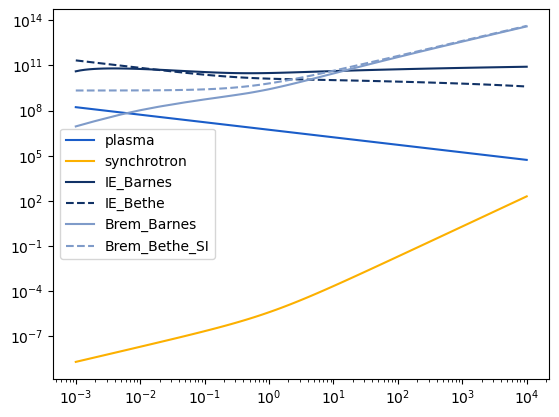

In [10]:
%matplotlib widget
Z_charge = Z
plot_rates(T, rho, B, Z, Z_charge, A, Brem=[Brem_Barnes, Brem_Bethe_SI], IE=[IE_Barnes, IE_Bethe])

In [11]:
%matplotlib widget
ratio = Brem_Bethe_SI(n_i, v_beta, E_beta, Z, Z_charge) / Brem_Barnes(n_i, v_beta, E_beta, Z, Z_charge)
plt.plot(E_beta, ratio)
plt.xscale('log')
plt.yscale('log')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Parameter exploration

We ll take a look at the losses as a function of $T$, $\rho$ and $B$.

The questions are:
- Can synchrotron dominate at some point in KN evolution?
- Can something else than Synchrotron dominate at some point in GRB afterglows?

In [12]:
%matplotlib inline
from ipywidgets import *

Tpe = widgets.Select(description='Ejecta type', 
                     options=['Hydrogen', 'Inner ejecta'], 
                     value='Inner ejecta')
IE = widgets.SelectMultiple(description='IE_losses',
                            options=['Barnes', 'Bethe (non-rel)'],
                            value=['Barnes'])
Brem = widgets.SelectMultiple(description='Bremsstrahlung',
                              options=['Barnes (Corrected)', 'Bethe_SI'],
                              value=['Barnes (Corrected)'])

T = widgets.FloatLogSlider(description='T', min=-10, max=10, value=1.e-6, step=1)
rho = widgets.FloatLogSlider(description='rho', min=-18, max=-10, value=1.e-14, step=1)
B = widgets.FloatLogSlider(description='B', min=-10, max=5, value=1.e-6, step=1)
Z = widgets.Dropdown(description='Z', options=[1,60], value=60)
A = widgets.Dropdown(description='A', options=[1,133,144], value=144)
params_ui = widgets.VBox([Tpe, Brem, IE,
                          T, rho, B, Z, A])

def update_Z_A(*args):
    if Tpe.value == 'Hydrogen':
        Z.value = 1
        A.value = 1
    if Tpe.value == 'Inner ejecta':
        Z.value = 60
        A.value = 144
    if Tpe.value == 'Outer':
        Z.value = 55
        A.value = 133
Tpe.observe(update_Z_A, 'value')

def update(Tpe, T, rho, B, Z, A, Brem, IE):
    
    Brem_dict = {"Barnes (Corrected)":Brem_Barnes, "Bethe_SI":Brem_Bethe_SI}
    Brem_opt = [Brem_dict[b] for b in Brem]
    IE_dict = {"Barnes":IE_Barnes, "Bethe (non-rel)":IE_Bethe}
    IE_opt = [IE_dict[i] for i in IE]
    
    plot_rates(T, rho, B, Z, Z, A, Brem=Brem_opt, IE=IE_opt)
        
out = widgets.interactive_output(update, 
                                 {'Tpe':Tpe, 'T': T, 'rho': rho, 'B': B, 'Z':Z, 'A':A, 'Brem':Brem, 'IE':IE})

ui = widgets.HBox([out, params_ui])
display(ui)


Now we need to evolve this following Meztger review for temperature and density.

A: Goes into homologuous expansion: $\rho \propto t^{-3}$. Quentin's work suggests that T might be increasing. In some models. T might go up to $10^{5}K$, but probably not above. 

hello

# Plotly visualisation

## Fixed parameters

In [13]:
E_beta = np.logspace(-3, 4, 100) # particle kinetic energy (MeV)    
Ibar = np.exp(6.4) * 1.e-6 # (MeV)

## Functions used for visualisation

In [14]:
%matplotlib inline
from ipywidgets import *
import pandas as pd
from plotly import graph_objs as go

In [15]:
Ts = np.logspace(-6, 0, 30)
rhos = np.logspace(-22, -10, 30)

def processes(E_beta, T, rho, B, Z, Z_charge, A, Brem=[Brem_Barnes], IE=[IE_Barnes]):
    
    n_eb = calc_n_eb(rho, Z/A)
    n_e = rho / (A * m_p_) * (1./Z)
    n_i = rho / (A*m_p_)
    
    gamma_beta = 1 + to_erg(E_beta) / (m_e_ * c_**2)
    v_beta = np.sqrt(1 - 1./gamma_beta**2) * c_
    
    plasma = plasma_losses(E_beta, n_e, T) / rho
    synch = synch_losses(v_beta, B) / rho
    
    IE = [f(E_beta, Ibar, v_beta, n_eb) / rho for f in IE]
    Brem = [f(n_i, v_beta, E_beta, Z, Z_charge) / rho for f in Brem]
    
    return(plasma, IE[0], Brem[0], synch)

def plotDominantProcess(E_beta_hm, Ts, rhos, B, Z, Z_charge, A, Brem=[Brem_Barnes], IE=[IE_Barnes]):
    
    T_arr = np.array([[T for T in Ts] for rho in rhos])
    rho_arr = np.array([[rho for T in Ts] for rho in rhos])
    procs = np.array([[processes(E_beta_hm, T, rho, B, Z, Z_charge, A, Brem, IE) for T in Ts] for rho in rhos])
    normprocs = np.maximum(0, procs/np.max(procs, axis=2, keepdims=True))
    print(normprocs[29,29,:])
    normprocs = normprocs/np.sum(normprocs, axis=2, keepdims=True)
    
    from plotly.subplots import make_subplots

    rcolorscale = [[0, 'rgba(255,0,0,0)'], [1, 'rgba(255,0,0,1)']]
    gcolorscale = [[0, 'rgba(0,255,0,0)'], [1, 'rgba(0,255,0,1)']]
    bcolorscale = [[0, 'rgba(0,0,255,0)'], [1, 'rgba(0,0,255,1)']]
    kcolorscale = [[0, 'rgba(0,0,0,0)'],   [1, 'rgba(0,0,0,1)']]

    plasma = go.Heatmap(z=normprocs[:,:,0], zmax=1, zmin=0, colorscale=rcolorscale,
                        customdata=np.dstack((procs[:,:,0], procs[:,:,1], procs[:,:,2], procs[:,:,3], T_arr, rho_arr)),
                        hovertemplate='E_dot_plasma: %{customdata[0]:.1e} <br>\
    E_dot_IE: %{customdata[1]:.1e} <br>\
    E_dot_Brem: %{customdata[2]:.1e} <br>\
    E_dot_synch: %{customdata[3]:.1e} ')
    IE = go.Heatmap(z=normprocs[:,:,1], zmax=1, zmin=0, colorscale=gcolorscale)
    Brem = go.Heatmap(z=normprocs[:,:,2], zmax=1, zmin=0, colorscale=bcolorscale)
    synch = go.Heatmap(z=normprocs[:,:,3], zmax=1, zmin=0, colorscale=kcolorscale)

    return(Brem, IE, synch, plasma)

In [16]:
Tpe = widgets.Select(description='Ejecta type', 
                     options=['Hydrogen', 'Inner ejecta', 'GRB afterglow'], 
                     value='Inner ejecta')
IE = widgets.SelectMultiple(description='IE_losses',
                            options=['Barnes', 'Bethe (non-rel)'],
                            value=['Barnes'])
Brem = widgets.SelectMultiple(description='Bremsstrahlung',
                              options=['Barnes (Corrected)', 'Bethe_SI'],
                              value=['Barnes (Corrected)'])

E_beta_eval = widgets.FloatLogSlider(description='E_beta', min=-3, max=5, value=0, step=1)
T = widgets.FloatLogSlider(description='T', min=-10, max=3, value=1.e-6, step=1)
rho = widgets.FloatLogSlider(description='rho', min=-18, max=-10, value=1.e-14, step=1)
B = widgets.FloatLogSlider(description='B', min=-10, max=5, value=1.e-6, step=1)
Z = widgets.Dropdown(description='Z', options=[1,60], value=60)
A = widgets.Dropdown(description='A', options=[1,133,144], value=144)

g = go.FigureWidget(data=[*plotDominantProcess(E_beta_eval.value, Ts, rhos, B.value, Z.value, Z_charge, A.value)])
g.update_layout(
    title="Dominant process",
    xaxis_title="Temperature T(K)",
    yaxis_title="Density rho(g/cm3)")

def update_Z_A(*args):
    if Tpe.value == 'Hydrogen':
        Z.value = 1
        A.value = 1
        T.value = 1.e-6
        B.value = 3.7e-6
    if Tpe.value == 'Inner ejecta':
        Z.value = 60
        A.value = 144
        T.value = 1.e-6
        B.value = 3.7e-6
    if Tpe.value == 'Outer':
        Z.value = 55
        A.value = 133
    if Tpe.value == 'GRB afterglow':
        Z.value = 1
        A.value = 1
        T.value = 1.e3  # max value measured in GAMMA (MeV)
        B.value = 1.e3  # in G
Tpe.observe(update_Z_A, 'value')

def update(Tpe, T, rho, B, Z, A, Brem, IE):
    
    Brem_dict = {"Barnes (Corrected)":Brem_Barnes, "Bethe_SI":Brem_Bethe_SI}
    Brem_opt = [Brem_dict[b] for b in Brem]
    IE_dict = {"Barnes":IE_Barnes, "Bethe (non-rel)":IE_Bethe}
    IE_opt = [IE_dict[i] for i in IE]
    
    plot_rates(T, rho, B, Z, Z, A, Brem=Brem_opt, IE=IE_opt)


def response(change):
    g.data = []
    with g.batch_update():
        procs = plotDominantProcess(E_beta_eval.value, Ts, rhos, B.value, Z.value, Z_charge, A.value)
        [g.add_trace(p) for p in procs]
    g.data[3].on_click(update_T_rho)

E_beta_eval.observe(response, "value")
B.observe(response, "value")
Tpe.observe(response, "value")

def update_T_rho(trace, points, state):
    
    inds = points.point_inds[0]
    T.value = trace.customdata[:,:,4][inds[0],inds[1]]
    rho.value = trace.customdata[:,:,5][inds[0],inds[1]]
    
g.data[3].on_click(update_T_rho)

[0.00000000e+00 1.00000000e+00 2.19628072e-04 6.38677515e-25]


## Visualisation

The heatmap shows how much each process (<font color='red'>plasma</font>, <font color='green'>IE</font>, <font color='blue'>bremsstrahlung</font>, **synchrotron**) dominates over the others for the value of `E_beta` chosen with the cursor.

- Hovering over the heatmap will update the figure showing the degradation processes as a function of kinetic energy.
- All parameters are in CGS Gaussian units

### Comments

- All the processes are expressed per unit density. So they don't evolve as when changing density, except for synchrotron as the energy loss is independent of the density.


- Changing temperature only influences the lower threshold in energy for plasma losses. Increasing temperature increases the energy threshold below which electrons cannot loose their energy (they can't communicate their energy to the thermal electrons.)


- Bethe IE losses don't include the relativistic correction that increases the losses at high energies.

In [17]:
lfac = 1.e5
elec_energy = (lfac - 1)*m_e_*c_**2
print(to_MeV(elec_energy))

51099.27585286005


In [18]:
# Layout
out = widgets.interactive_output(update, 
                                 {'Tpe':Tpe, 'T': T, 'rho': rho, 'B': B, 'Z':Z, 'A':A, 'Brem':Brem, 'IE':IE})
ZA_ui = widgets.VBox([Z, A])
compo_ui = widgets.HBox([Tpe, ZA_ui])
select_ui = widgets.HBox([Brem, IE])
cursors_ui = widgets.VBox([E_beta_eval, T, rho, B])
params_ui = widgets.HBox([select_ui, cursors_ui])
ui = widgets.HBox([out, g])
f = widgets.VBox([compo_ui, params_ui, ui])
display(f)

[0.00000000e+00 1.00000000e+00 1.52679642e-02 7.83870314e-23]
[1.49211362e-06 1.55209954e-01 1.00000000e+00 7.19111415e-19]
[3.81011430e-05 1.00000000e+00 6.94298012e-01 6.63964212e-20]
[8.43694185e-05 1.00000000e+00 8.39910007e-02 1.64076167e-21]
[3.81011430e-05 1.00000000e+00 6.94298012e-01 6.63964212e-20]
[8.43694185e-05 1.00000000e+00 8.39910007e-02 1.64076167e-21]
[0.00000000e+00 1.00000000e+00 1.52679642e-02 7.83870314e-23]
[0.00000000e+00 1.00000000e+00 1.82144827e-03 4.49770726e-24]
[0.00000000e+00 1.00000000e+00 2.19628072e-04 6.38677515e-25]
[0.00000000e+00 1.00000000e+00 2.19628072e-04 6.38677515e-17]
[0.00000000e+00 1.00000000e+00 2.19628072e-04 6.38677515e-11]
[0.00000000e+00 1.00000000e+00 2.19628072e-04 6.38677515e-23]
[0.00000000e+00 1.00000000e+00 2.19628072e-04 6.38677515e-17]
[0.00000000e+00 1.00000000e+00 2.19628072e-04 6.38677515e-13]
[0.00000000e+00 1.00000000e+00 2.19628072e-04 6.38677515e-05]
[0.00000000e+00 1.00000000e+00 2.19628072e-04 6.38677515e-07]
[0.00000